# Letal COVID-19 snRNA Analysis
# Section 4: Dimensionality Reduction
Author: MikiasHWT  
Start: December 9, 2024  

In [1]:
from datetime import datetime
current_date = datetime.now().strftime("%B %d, %Y")
print(f"Updated: {current_date}")

Updated: December 19, 2024


# Background

Once we have subset our genes to the most informative subsets, we are still left with more genes than the human mind can easily comprehend. Additionally high dimensional data does not always mean informative data, much of the information we have on hand could be a product of noise and various other artifacts. This is where unsupervised machine learning methods such as clustering and dimensionality reduction come into play. These methods take the 2000+/- genes in our data and without any labels to inform grouping (unsupervised) they apply various statistical methods to reduce the number of dimensions to a handful of informative dimensions. 

## Objective

- Reduce the number of dimensions in the data
- Compare various methods
- Cluster by cell types
- Determine appropriate resolutions

# Prep Workspace

## Import Libraries

In [2]:
# Default 
import numpy as np  # Numerical computing library
import pandas as pd  # Data manipulation and analysis
import matplotlib.pyplot as plt  # Plotting and visualization
import seaborn as sns  # Statistical data visualization
import scanpy as sc  # Single-cell data analysis
import os  # Operating system interface

sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False,
)

## Define Functions

## Directories

In [3]:
# Define directories 
datDir = os.path.abspath("data")
outDir = os.path.abspath("output")

## Import Data

In [4]:
# Read single sample we QC'd & Normalized in previous sections
adata = sc.read_h5ad("data/C51ctr_HVG.h5ad")
adata

AnnData object with n_obs × n_vars = 6094 × 24660
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'size_factors'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_deviant', 'binomial_deviance', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'outlier_temp_colors'
    layers: 'counts', 'log1p-CP10K', 'log1p-CPM', 'log1p-median', 'pearson_residuals', 'scran_normalization'

## Markers of Interest

In [5]:
# Common markers List to compare feature selection methods
markers = ["HLA-E", "CD4", "PTPRC", "IGHM", "ITGAX"]

# Clustering & Dimensionality Reduction

## PCA

As always various methods exist and are continuesly refined. Some default apporaches include:

- `Principle Component Analysis (PCA)`: Finds linear combinations of features that maximaize variance and groups them into sets of principle components.
    - An old method but still widely used
    - Excellent for reducing dimensinality for downstream workflows. 
    - Not great with visualization

In [6]:
# Compute Principle Components with logp1 scaled values and highly deviant boolean mask
sc.pp.pca(adata, svd_solver="arpack", layer='log1p-median', mask_var="highly_deviant")
adata

AnnData object with n_obs × n_vars = 6094 × 24660
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'size_factors'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_deviant', 'binomial_deviance', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'outlier_temp_colors', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts', 'log1p-CP10K', 'log1p-CPM', 'log1p-median', 'pearson_residuals', 'scran_normalization'

We note that we have included additional variables into our Anndata object after running PCA. Specifically we have the default addition of 50 Priniciple Components. 

In [7]:
adata.uns["pca"]

{'params': {'zero_center': True,
  'use_highly_variable': False,
  'mask_var': 'highly_deviant',
  'layer': 'log1p-median'},
 'variance': array([19.350769  , 10.730766  ,  8.291792  ,  6.4393015 ,  5.639369  ,
         4.5078864 ,  1.9534283 ,  1.5993677 ,  1.5141072 ,  1.4138693 ,
         1.3006952 ,  1.1917288 ,  0.95108193,  0.860114  ,  0.73840135,
         0.63759667,  0.61782163,  0.5797722 ,  0.5673179 ,  0.5359464 ,
         0.52112365,  0.50026095,  0.4707884 ,  0.45565283,  0.44855   ,
         0.43907705,  0.43451795,  0.4301262 ,  0.41883588,  0.41299918,
         0.40174055,  0.39847857,  0.39649448,  0.38271743,  0.38121113,
         0.37801683,  0.3742257 ,  0.36861104,  0.36795136,  0.3666295 ,
         0.36460093,  0.3583969 ,  0.3558015 ,  0.35310864,  0.35115793,
         0.34810534,  0.34342784,  0.34136242,  0.338555  ,  0.33640563],
       dtype=float32),
 'variance_ratio': array([0.07364926, 0.04084143, 0.03155866, 0.02450806, 0.02146351,
        0.01715707, 0.0

We can use a variance ratio plot (aka: elbow plot) to visualize the impact of each PC on the variance of the data. The Y-Axis denotes the amount of variance that the given X value describes. This plot can be used to identify the number of PC's that provide meaningful insight into the data, this is done by identifying the elbox joint in the plot (the point in the plot where additional PC's do not account for much more variability in the data). In the spirit of permissive filtering, it is accepted practice to slightly overshoot the elbow point. In the plot below, i might select anywhere from 10-20 PC's to move forward with the analysis. Experts generally agree that the choice of number of PC's isnt incredibly important to final outcome of analysis. 

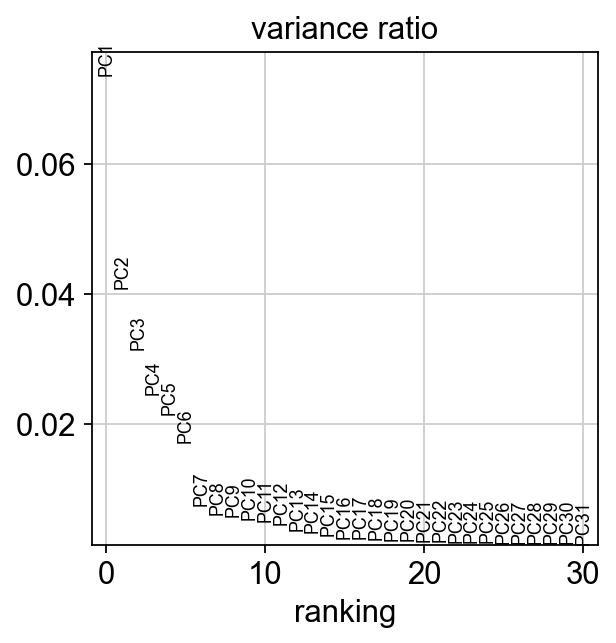

In [8]:
# Plot elbow curve
sc.pl.pca_variance_ratio(adata)

Additionally we can inspect the PCA loadings to determine the genes and their linear combinations that are influencing our first few PC's. 

c:\Users\Owner\Documents\GitHub\scRNA_Lethal_Covid19_Analysis\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8942 (\N{VERTICAL ELLIPSIS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


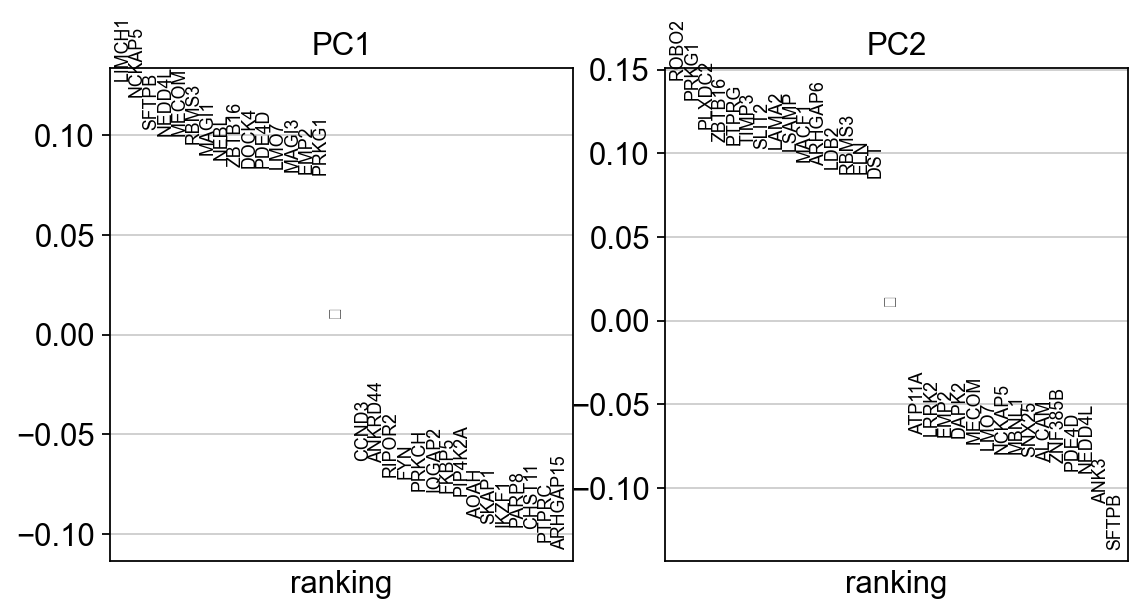

In [9]:
sc.pl.pca_loadings(adata, components = '1,2');

Lastly we can plot the first two PC's (or any others) to visualize how well the cells are groups. (this result is generally not very informative)

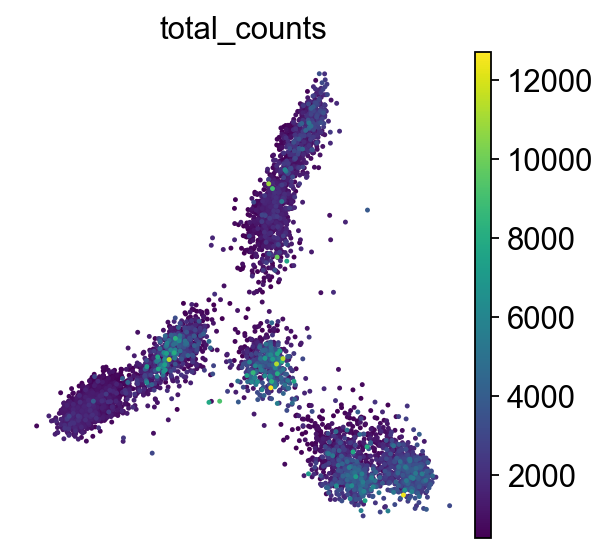

In [10]:
# Visualize
sc.pl.pca_scatter(adata, color="total_counts")

## tSNE

- `Stochastic Neighbor Embedding (tSNE)`: Uses pair wise similarties to reduce the dimensionaity of data
    - Can be computationally expensive for large datasets

In [11]:
# Apply tSNE
sc.tl.tsne(adata, use_rep="X_pca")
adata

AnnData object with n_obs × n_vars = 6094 × 24660
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'size_factors'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_deviant', 'binomial_deviance', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'outlier_temp_colors', 'pca', 'tsne'
    obsm: 'X_pca', 'X_tsne'
    varm: 'PCs'
    layers: 'counts', 'log1p-CP10K', 'log1p-CPM', 'log1p-median', 'pearson_residuals', 'scran_normalization'

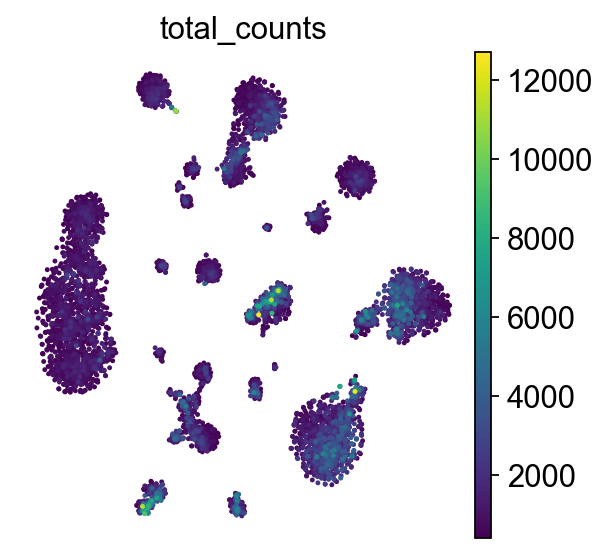

In [12]:
# Visualize tSNE
sc.pl.tsne(adata, color="total_counts")

## UMAP

- `Uniform Manifold Approximation and Projection (UMAP)`: Applies k-nearest neighbors approach to high dimensional data. 
    - Highly stable and does an excelent job at seperating cell types

In [13]:
# UMAP
sc.pp.neighbors(adata)
sc.tl.umap(adata)
adata

c:\Users\Owner\Documents\GitHub\scRNA_Lethal_Covid19_Analysis\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


AnnData object with n_obs × n_vars = 6094 × 24660
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'size_factors'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_deviant', 'binomial_deviance', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'outlier_temp_colors', 'pca', 'tsne', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'log1p-CP10K', 'log1p-CPM', 'log1p-median', 'pearson_residuals', 'scran_normalization'
    obsp: 'distances', 'connectivities'

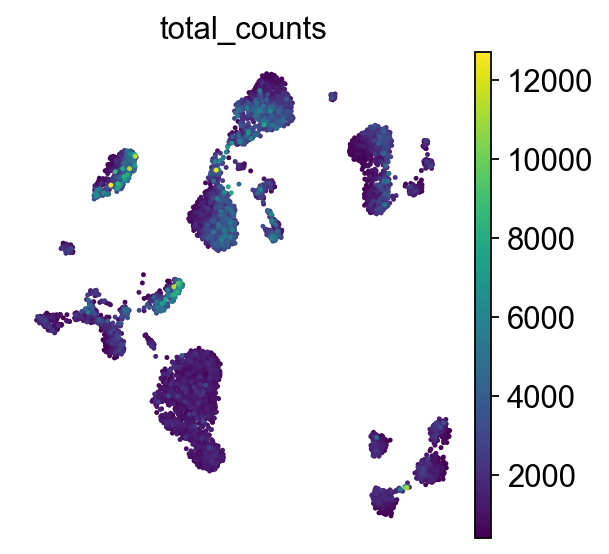

In [14]:
# Plot
sc.pl.umap(adata, color="total_counts")

## Explore Data

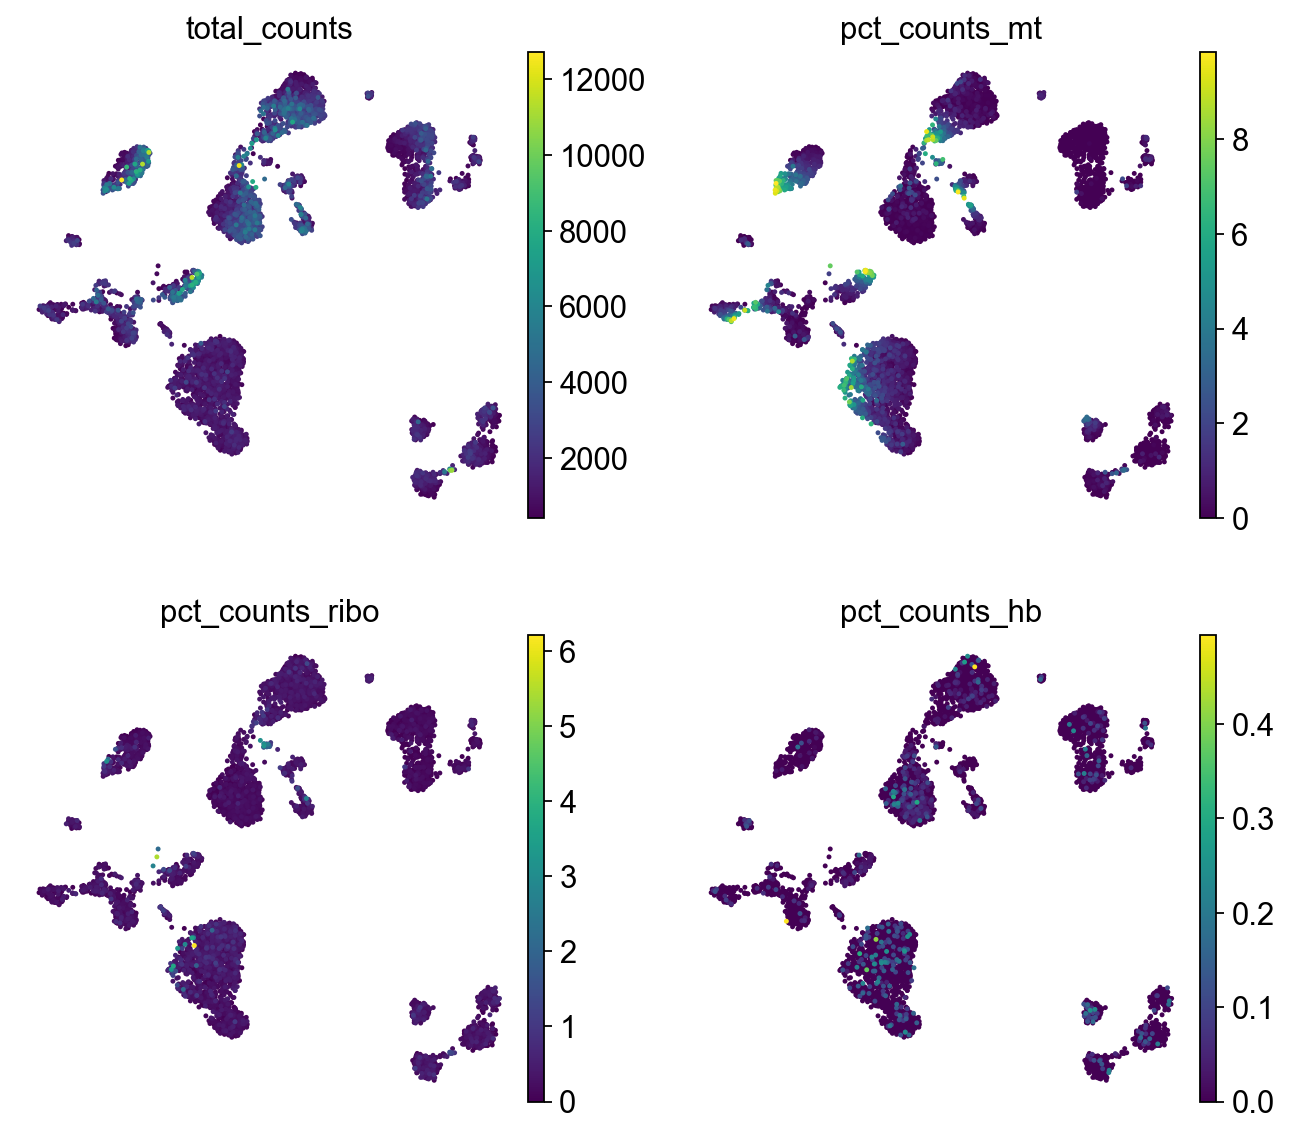

In [15]:
# Inspect quality control 
sc.pl.umap(
    adata,
    color=["total_counts", "pct_counts_mt", "pct_counts_ribo", "pct_counts_hb"],
    ncols=2
)

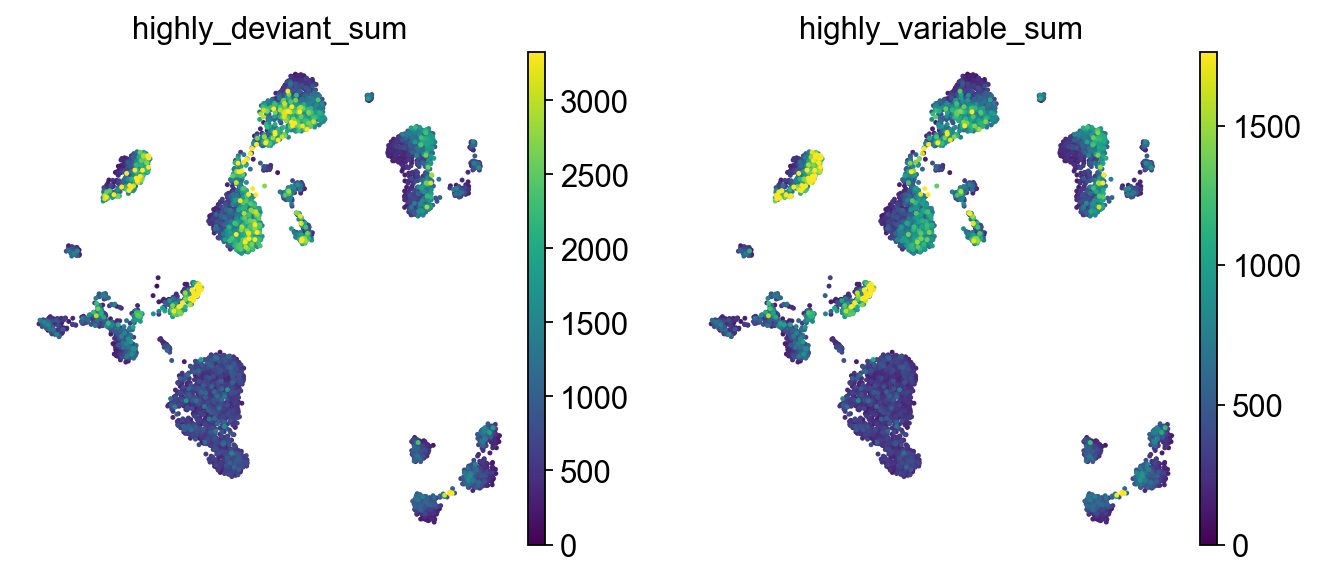

In [16]:
# Color UMAP by cell's sum of deviant & variable genes.
adata.obs['highly_deviant_sum'] = adata[:, adata.var['highly_deviant']].X.sum(axis=1)
adata.obs['highly_variable_sum'] = adata[:, adata.var['highly_variable']].X.sum(axis=1)

sc.pl.umap(
    adata,
    color=['highly_deviant_sum', 'highly_variable_sum'],
    ncols=2,
    vmin=0, 
    vmax="p99"
)

In [17]:
# Extract most influencial genes from first Principle Component
top_genes_pc1 = adata.var_names[abs(adata.varm['PCs'][:, 0]).argsort()[::-1][:15]].tolist()

top_genes_pc1

['LIMCH1',
 'NCKAP5',
 'ARHGAP15',
 'PTPRC',
 'SFTPB',
 'NEDD4L',
 'MECOM',
 'CHST11',
 'PARP8',
 'IKZF1',
 'RBMS3',
 'SKAP1',
 'AOAH',
 'MAGI1',
 'NEBL']

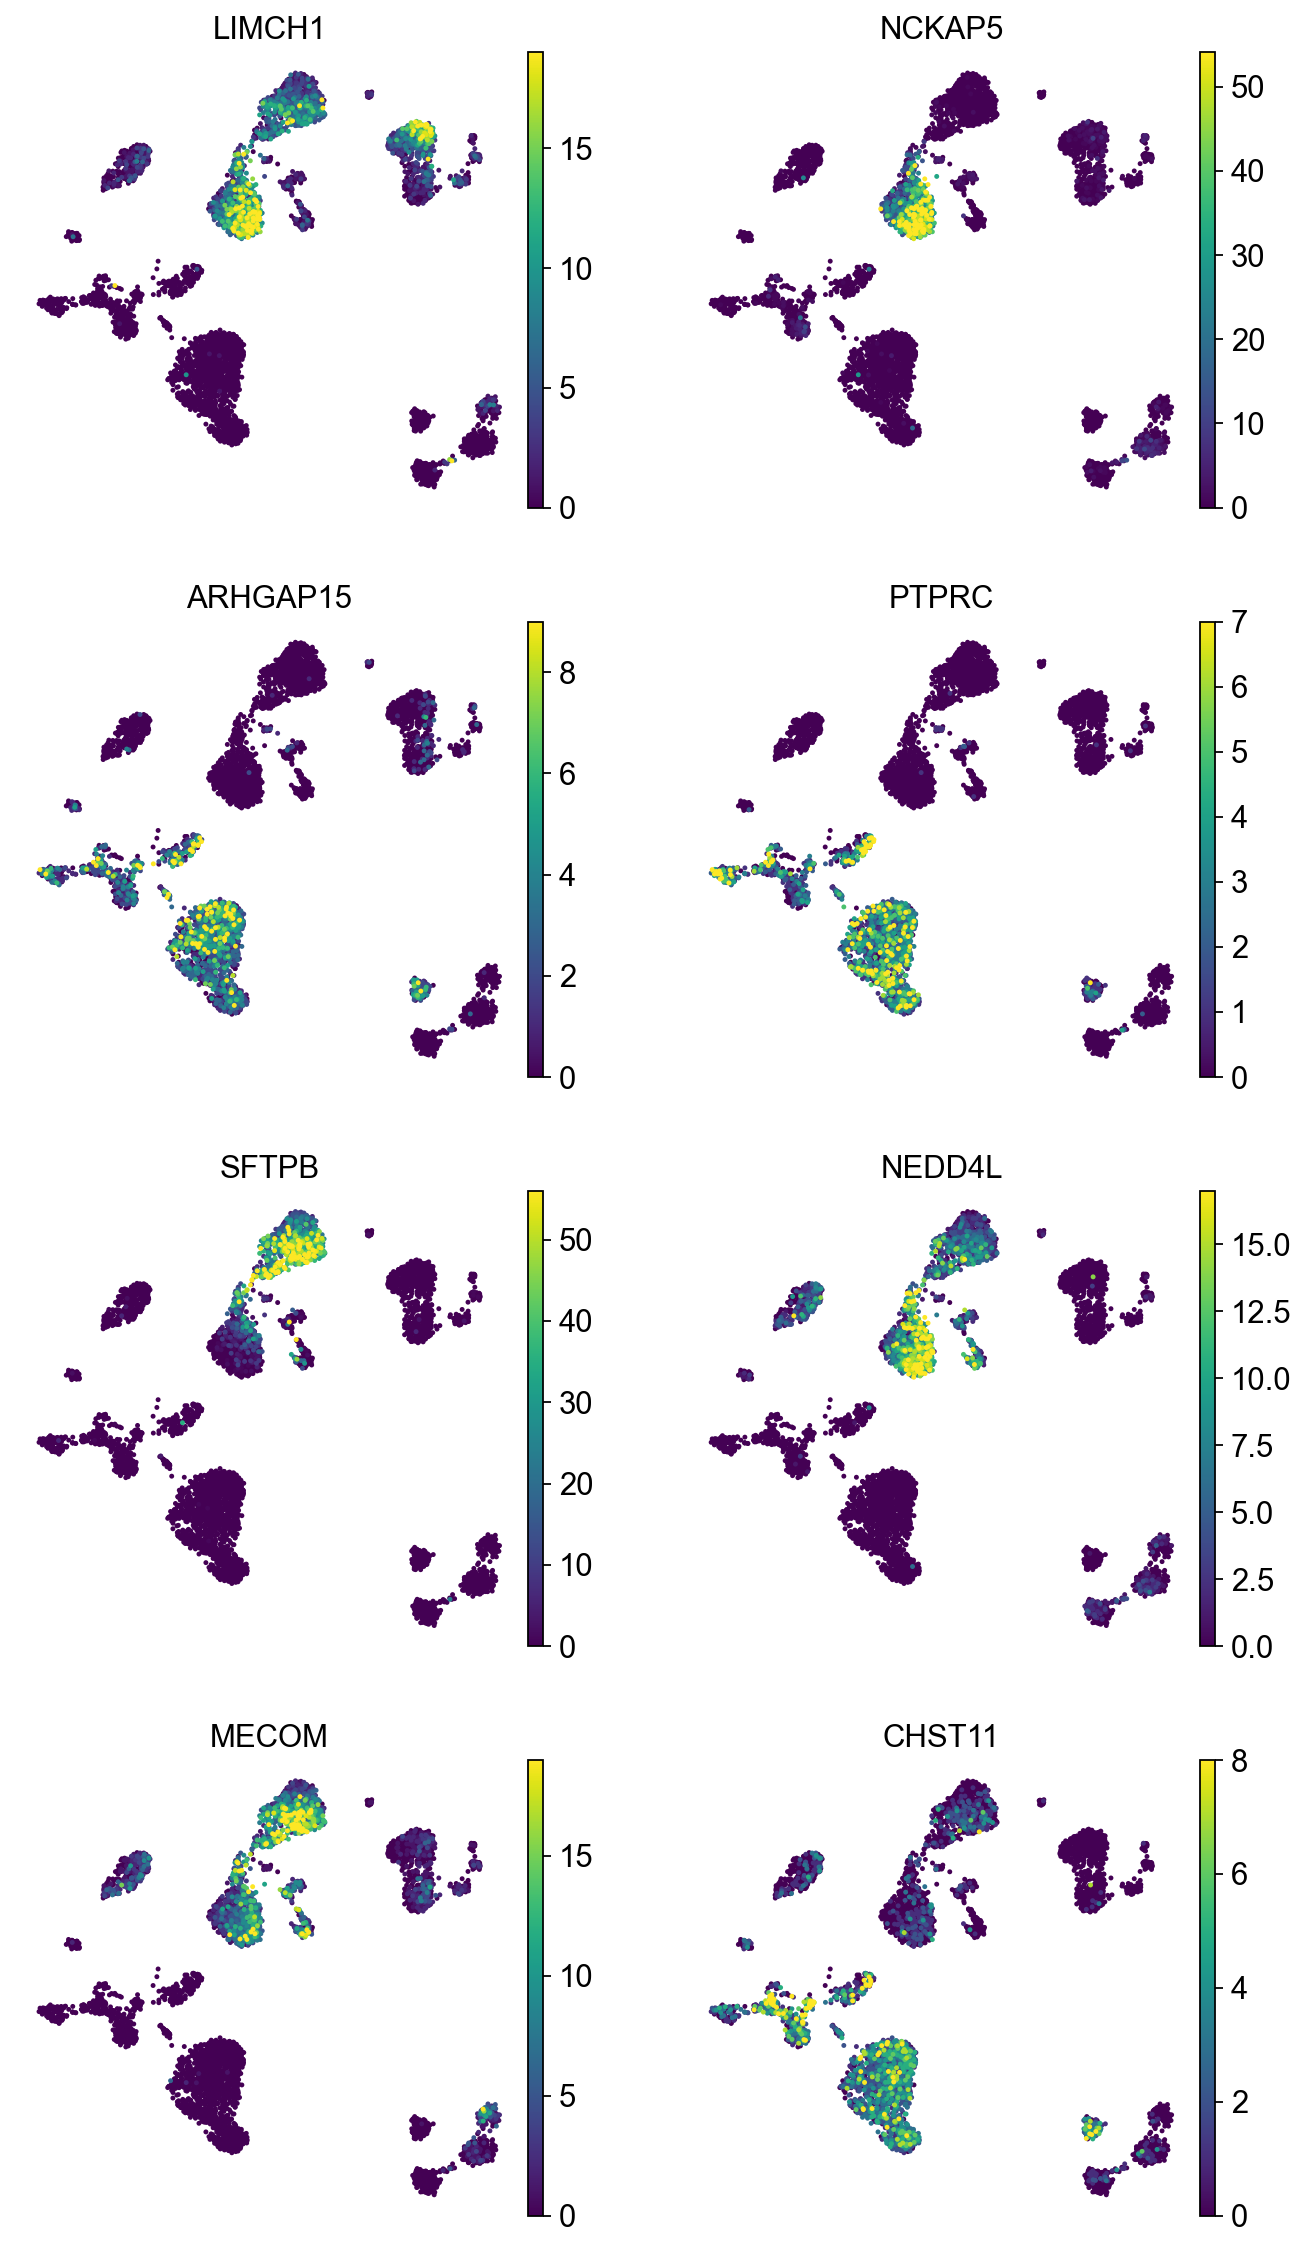

In [18]:
# Check Top markers
sc.pl.umap(adata, color=top_genes_pc1[:8], ncols=2, vmin=0, vmax="p99")

# Define Cell Boundries

In order to computationally determine the cluster assignments, we utlize Leiden clustering. [From Louvain to Leiden: guaranteeing well-connected communities](https://www.nature.com/articles/s41598-019-41695-z). Leiden clustering uses K Nearest Neighbores (KNN) method to groups cells based on a predefined (but meaningless) resolution metric (default is 1.0, higher values product more clusters). This requires some refinement and can be further optimized by increasing the resolution of a subcluster. 

In [19]:
# Call Leiden algoritm with various resolutions 
for res in [0.02, 0.5, 1.0, 2.0]:
    sc.tl.leiden(
        adata, key_added=f"leiden_res_{res:4.2f}", resolution=res) # flavor="igraph", n_iterations=2)
    
adata

C:\Users\Owner\AppData\Local\Temp\ipykernel_17176\220426450.py:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(


AnnData object with n_obs × n_vars = 6094 × 24660
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'size_factors', 'highly_deviant_sum', 'highly_variable_sum', 'leiden_res_0.02', 'leiden_res_0.50', 'leiden_res_1.00', 'leiden_res_2.00'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_deviant', 'binomial_deviance', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'outlier_temp_colors', 'pca', 'tsne', 'neighbors', 'umap', 'leiden_res_0.02', 'leiden_res_0.50', 'leiden_res_1.00', 'leiden_res_2.00'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'l

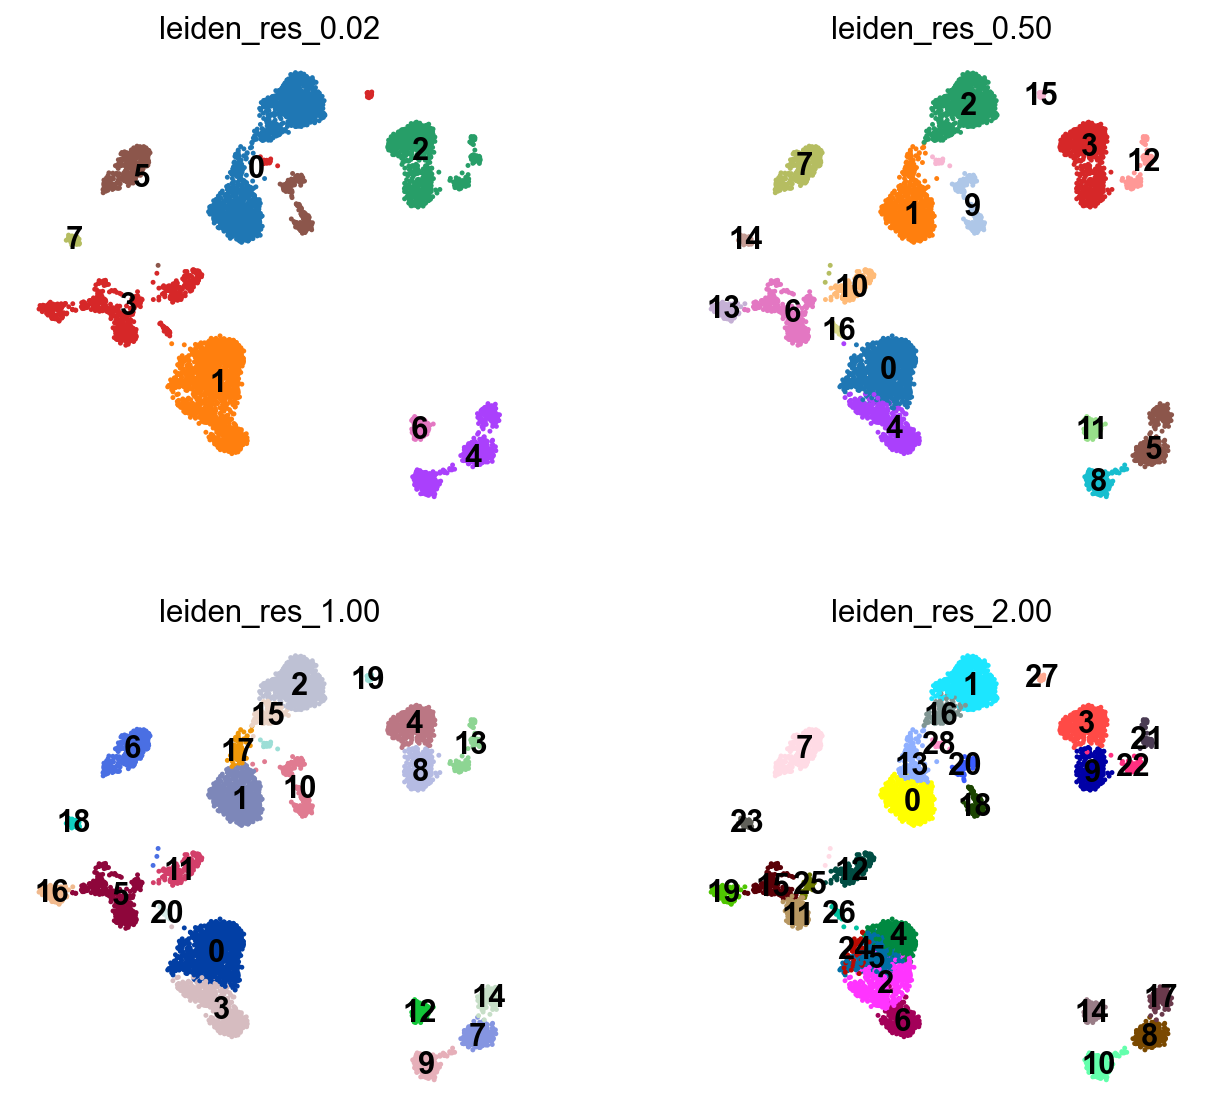

In [20]:
# Visualize outputs
sc.pl.umap(
    adata,
    color=["leiden_res_0.02", "leiden_res_0.50", "leiden_res_1.00", "leiden_res_2.00"],
    legend_loc="on data",
    ncols=2
)

## Save Object

In [21]:
# Save object
adata.write("data/C51ctr_Clustered.h5ad")

# End Session

In [22]:
import session_info
session_info.show()

c:\Users\Owner\Documents\GitHub\scRNA_Lethal_Covid19_Analysis\.venv\Lib\site-packages\session_info\main.py:213: UserWarning: The '__version__' attribute is deprecated and will be removed in MarkupSafe 3.1. Use feature detection, or `importlib.metadata.version("markupsafe")`, instead.
  mod_version = _find_version(mod.__version__)
